# Yolov7 theory and hands-on implementation
## Yolov7 architecture
The following image shows the yolov7 architecture. This architecture could be followed in order to hands-on program the architecture, so we will need to follow it.
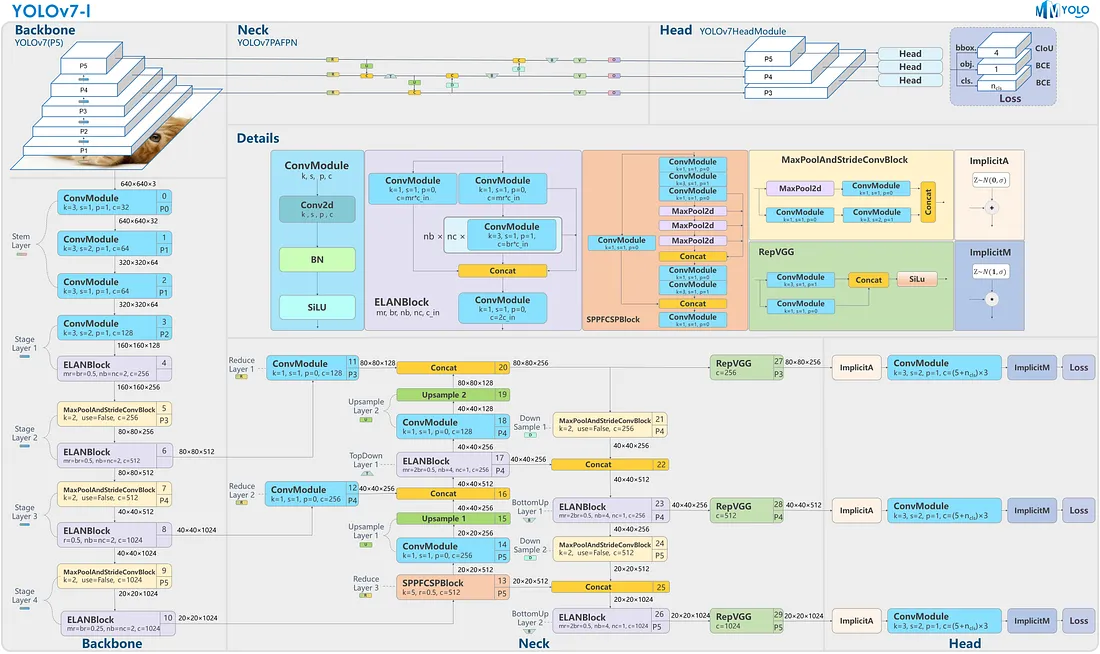

One of the new aspects of this architecture is the ELAN (Efficient Layer Aggregation Networks) network. Feature aggregation is a widely used technique that ensures the maintenance of information from layer to layer, so that knowledge and information are not lost, and image transformation and rescaling do not lose important information for the network.
Implementation of Feature Aggregation in ELAN (YOLOv7)

* Feature Concatenation: The outputs of several layers are concatenated along the channel dimension.
* Feature Addition: The outputs of several layers are summed element-wise. This can reinforce certain important features and smooth out those that are less relevant.
* Multi-Scale Aggregation: Feature aggregation is performed at multiple scales. This means that features from different resolutions and levels of the network are combined, allowing for better detection of objects of different sizes.
* Skip Connections: Features from earlier layers are directly added to later layers. This helps mitigate the problem of gradient vanishing and allows deeper layers to access more primitive features.

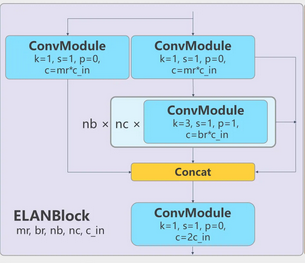

In [ ]:
# Implementation with comments of the ELAN following the drawing
import torch
import torch.nn as nn

class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class ELANBlock(nn.Module):
    def __init__(self, c_in, mr, br, nb, nc):
        super(ELANBlock, self).__init__()
        self.conv1 = ConvModule(c_in, mr * c_in, kernel_size=1, stride=1, padding=0)
        self.conv2 = ConvModule(c_in, mr * c_in, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvModule(mr * c_in, br * c_in, kernel_size=3, stride=1, padding=1)
        self.conv4 = ConvModule(nb * c_in, 2 * c_in, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x2)

        x_concat = torch.cat((x1, x3), dim=1)
        x_out = self.conv4(x_concat)

        return x_out

# Prueba del bloque ELAN
input_tensor = torch.randn(1, 64, 256, 256)  # Tensor de ejemplo con batch_size=1, channels=64, height=256, width=256
elan_block = ELANBlock(c_in=64, mr=1, br=1, nb=2, nc=1)
output = elan_block(input_tensor)
print(output.shape)  # Salida del bloque ELAN


torch.Size([1, 128, 256, 256])


## Compound Model Scaling
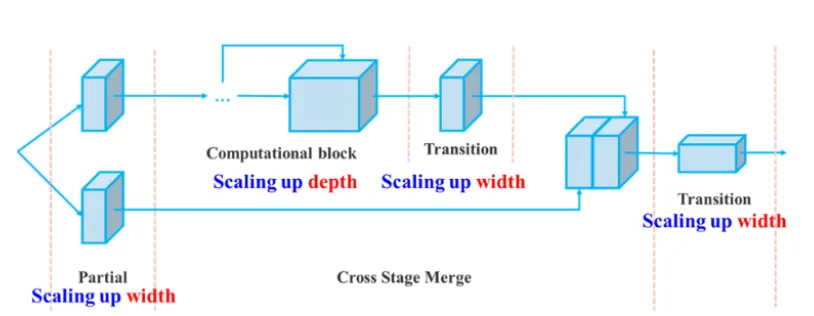
Depth scaling in YOLOv7 refers to increasing the number of layers in the network to enhance its ability to learn complex features from the data. Here's a brief overview:

- Purpose:
        To improve the network's capacity to capture detailed and high-level features, leading to better performance in object detection.

- Implementation:
        Computational Blocks: More layers (e.g., convolutional layers) are added within these blocks to process and extract features more effectively.
        Feature Extraction: Additional layers enable the network to build upon previously extracted features, creating a more refined understanding of the input.

- Balancing:
        Increased depth is balanced with width scaling (managing the number of channels) to keep the network efficient and manageable.

- Benefits:
        Improved Accuracy: More layers help the network learn complex patterns, enhancing detection accuracy.
        Better Generalization: Deeper networks can generalize better to new data, improving performance on unseen examples.

In summary, depth scaling in YOLOv7 involves adding layers to increase learning capacity, resulting in improved accuracy and generalization while balancing computational efficiency.

# Global differences
YOLOv7, as an evolution in the YOLO (You Only Look Once) series of object detectors, brings several advancements and improvements over its predecessors. Here are the main differences and innovations introduced in YOLOv7 compared to earlier versions like YOLOv4 and YOLOv5:

* **Model Architecture Enhancements:**
Efficient Layer Aggregation Networks (ELAN): YOLOv7 introduces ELAN to improve the learning ability of deep models, allowing better feature propagation and gradient flow.
* **Cross-Stage Partial Networks (CSPNet):** Used extensively in YOLOv7 to reduce the model size while maintaining high accuracy, enhancing the efficiency and speed of the network.

* **Anchor-Free Detection:**
YOLOv7 employs an anchor-free detection approach which simplifies the model design and improves detection performance, especially for objects of varying scales and aspect ratios.

* **Improved Training Strategies:**
Auxiliary Head Network: YOLOv7 includes auxiliary heads in the training process, which helps in optimizing the feature extraction layers and improves the overall accuracy.
        
* **Self-Adversarial Training (SAT):** A technique to enhance the model's robustness by generating adversarial examples during training, helping the model generalize better to new data.

* **Dynamic Label Assignment:**
YOLOv7 uses a dynamic label assignment strategy during training, which improves the matching of predicted boxes to ground truth boxes, leading to better localization and classification performance.

* **Better Trade-Off Between Speed and Accuracy:**
YOLOv7 provides a balanced trade-off between inference speed and detection accuracy, making it suitable for real-time applications. This includes optimizations for both GPU and CPU inference.

* **Advanced Post-Processing Techniques:**
The model introduces advanced non-maximum suppression (NMS) techniques, such as Soft-NMS and DIoU-NMS, which help in reducing the number of false positives and improving the precision of detections.

* **Enhanced Feature Fusion:**
YOLOv7 includes better feature fusion techniques, combining features from different layers more effectively to capture both low-level and high-level information.

* **Improved Backbone Networks:**
The backbone networks in YOLOv7 are designed to be more efficient, utilizing advanced components like CSPDarknet, which contribute to better feature extraction with fewer parameters.

Overall, YOLOv7 focuses on enhancing the efficiency, accuracy, and robustness of object detection models, building on the successes of its predecessors while introducing significant architectural innovations and training improvements.

# Hands-on programming

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, SiLU, MaxPooling2D, Concatenate, UpSampling2D, Input, Add
from tensorflow.keras.models import Model

# Helper function to create ConvModule
def ConvModule(x, filters, kernel_size, strides, padding, activation=True):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    if activation:
        x = SiLU()(x)
    return x

# ELANBlock
def ELANBlock(x, filters):
    x1 = ConvModule(x, filters, 1, 1, 'same')
    x2 = ConvModule(x1, filters, 3, 1, 'same')
    x3 = ConvModule(x2, filters, 3, 1, 'same')
    x4 = ConvModule(x3, filters, 3, 1, 'same')
    x = Concatenate()([x1, x2, x3, x4])
    x = ConvModule(x, filters, 1, 1, 'same', activation=False)
    return x

# RepVGG block
def RepVGGBlock(x, filters):
    x1 = ConvModule(x, filters, 3, 1, 'same')
    x2 = ConvModule(x, filters, 1, 1, 'same', activation=False)
    x = Concatenate()([x1, x2])
    return x

# SPPF Block
def SPPFBlock(x, filters):
    x1 = MaxPooling2D(pool_size=5, strides=1, padding='same')(x)
    x2 = MaxPooling2D(pool_size=9, strides=1, padding='same')(x)
    x3 = MaxPooling2D(pool_size=13, strides=1, padding='same')(x)
    x = Concatenate()([x, x1, x2, x3])
    x = ConvModule(x, filters, 1, 1, 'same')
    return x

# Neck Block
def YOLOv7_Neck(x, p3, p4, p5):
    # First reduce layer
    p5 = ConvModule(p5, 128, 1, 1, 'same')
    p5 = UpSampling2D()(p5)
    p4 = ConvModule(p4, 128, 1, 1, 'same')
    x = Concatenate()([p5, p4])

    # Second reduce layer
    x = ELANBlock(x, 256)
    p4 = ConvModule(p4, 128, 1, 1, 'same')
    p4 = UpSampling2D()(p4)
    p3 = ConvModule(p3, 128, 1, 1, 'same')
    x = Concatenate()([p4, p3])

    # Combine with previous layers
    x = ELANBlock(x, 512)

    return x

# Backbone and Neck
def YOLOv7_Backbone(input_shape):
    inputs = Input(shape=input_shape)
    x = ConvModule(inputs, 32, 3, 1, 'same')  # Stem layer

    # Stage 1
    x = ConvModule(x, 64, 3, 2, 'same')
    x = ELANBlock(x, 128)

    # Stage 2
    p3 = x
    x = ConvModule(x, 128, 3, 2, 'same')
    x = ELANBlock(x, 256)

    # Stage 3
    p4 = x
    x = ConvModule(x, 256, 3, 2, 'same')
    x = ELANBlock(x, 512)

    # Stage 4
    p5 = x
    x = ConvModule(x, 512, 3, 2, 'same')
    x = ELANBlock(x, 1024)

    model = Model(inputs, [p3, p4, p5, x])
    return model

# YOLOv7 Head
def YOLOv7_Head(x):
    x = ConvModule(x, 256, 1, 1, 'same')
    x = UpSampling2D()(x)
    x = Concatenate()([x, x])  # Replace 'x' with corresponding feature map from the neck

    x = ConvModule(x, 512, 3, 1, 'same')
    x = SPPFBlock(x, 256)

    # Output layer
    output = Conv2D(255, 1, 1, 'same')(x)  # Adjust filters according to your number of classes

    return output

# Full YOLOv7 model
def YOLOv7(input_shape):
    inputs = Input(shape=input_shape)
    backbone = YOLOv7_Backbone(input_shape)(inputs)
    neck = YOLOv7_Neck(backbone[3], backbone[0], backbone[1], backbone[2])
    head = YOLOv7_Head(neck)

    model = Model(inputs, head)
    return model

# Define input shape
input_shape = (640, 640, 3)

# Create YOLOv7 model
yolov7_model = YOLOv7(input_shape)

# Print model summary
yolov7_model.summary()


ImportError: cannot import name 'SiLU' from 'tensorflow.keras.layers' (/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/layers/__init__.py)

Layer Descriptions

* ConvModule: A basic convolution module consisting of Conv2D, BatchNormalization, and SiLU activation layers.
* ELANBlock: A custom block with multiple convolution layers and concatenations designed to aggregate features.
* RepVGGBlock: A simplified block for demonstration.
* SPPFBlock: A spatial pyramid pooling convolution block.
* YOLOv7_Neck: The neck part that combines reduction layers, upsampling, and ELAN blocks.
* YOLOv7_Backbone: The backbone network that includes all blocks and the stem layer.
* YOLOv7_Head: The head of the network that includes convolution blocks and the output layer.
* YOLOv7: The complete model that combines all the above parts.